In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import IPython

---
## Question 1:

Read chapter 4 from Haykin’s book (2nd edition), starting from section 4.1 to 4.6(including 4.6). Summarize or sketch your insights in mind-map or an outline or a summary.

---
## Question 2:

For this task you have to program the back-propogation (BP) for multi layered perceptron (MLP). Design your implementation for general NN with arbitrary many hidden layers. The test case is as follows:  2-2-1 multi layered perceptron (MLP) with sigmoid activation function on XOR data.

In [3]:
class NeuralNetwork():
    """
    3 layer neural network with 1 input layer, 1 hidden layer, 
    1 output layer...
    2-2-1 Neural Network..
    """
    def __init__(self, num_hidden_neurons = 2, learning_rate = 1, epochs = 100000,
                 num_inputs = 2, zero_weight_init = False, epsilon= 1e-10):
        # Layer 0 --> input, Layer 1 --> hidden, Layer 2 --> output
        if zero_weight_init == False:
            np.random.seed(0)
            # weights randomly initialized...
            self.w_layer01 = np.random.rand(num_inputs, num_hidden_neurons)
            self.w_layer12 = np.random.rand(num_hidden_neurons, 1)
        else:
            # weights initialized to zero...
            self.w_layer01 = np.zeros((num_inputs, num_hidden_neurons))
            self.w_layer12 = np.zeros((num_hidden_neurons, 1))
            
        self.num_hidden_neurons = num_hidden_neurons
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epochs = epochs
        
    def non_linearity(self, value, derivative = False):
        if derivative == True: # return slope of sigmoid..
            return value*(1. - value)
        # included to avoid overflow in numpy exponent..
        value = np.array(value, dtype = np.float128)
        value = np.clip( value, -500, 500 )
        # return sigmoid activation value...
        return 1./(1. + np.exp(-value)) 
        
    def train(self, input_array, output_array):
        iteration, prev_delta = 0, 1.
        conv_count = 0
        while(True):
            layer0 = input_array
            layer1_local_field = input_array.dot(self.w_layer01)
            layer1_output = self.non_linearity(layer1_local_field)
            
            layer2_local_field = layer1_output.dot(self.w_layer12)
            layer2_output = self.non_linearity(layer2_local_field)
        
            layer2_error = -(output_array - layer2_output)
            layer2_delta = layer2_error * self.non_linearity(
                layer2_error, derivative = True)
        
            layer1_error = layer2_delta.dot(self.w_layer12.T)
            layer1_delta = layer1_error * self.non_linearity(
                layer1_error, derivative = True)
            
            # update weights based on error and slope of sigmoid...
            self.w_layer12 -= self.learning_rate * (
                layer1_output.T.dot(layer2_delta))
            self.w_layer01 -= self.learning_rate * (
                layer0.T.dot(layer1_delta))
            
            delta = np.mean(np.abs(layer2_delta))
            check_convergence = prev_delta - delta
            training_error = np.mean(np.abs(layer2_error))
            
            if check_convergence < self.epsilon:
                conv_count += 1
            else:
                conv_count = 0
            
            if iteration % 3000 == 0:
                print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            if iteration > self.epochs or conv_count >= 3: # low delta for more than 3 epochs..
                break
            
            prev_delta = delta.copy()
            iteration += 1
                
        # training error at the end of epochs is returned...
        print '-----------------------------------------------------------'
        if iteration > self.epochs:
            print 'Max epochs reached...'
        else:
            print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            print 'Error has converged...'
        print '-----------------------------------------------------------'
        return [training_error, iteration]
                
    def predict(self, input_array, desired_array):
        layer0 = input_array
        layer1_local_field = input_array.dot(self.w_layer01)
        layer1_output = self.non_linearity(layer1_local_field)
        
        layer2_local_field = layer1_output.dot(self.w_layer12)
        layer2_output = self.non_linearity(layer2_local_field)
        
        layer2_error = layer2_output - desired_array
        
        # average generalization error is returned..
        return np.mean(np.abs(layer2_error))

In [4]:
# XOR..
input_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
labels = np.array([0, 0.01, 0.01, 0]).reshape(-1, 1)

print input_data.shape
print labels.shape

(4, 2)
(4, 1)


## 2) a) Experiments with initial weights

### i) Train the network with zero initial weights i.e. $w_{ij} = 0$.

In [5]:
network = NeuralNetwork(zero_weight_init= True)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.495
Epoch:  3000 ...... Training Error:  0.00808339520526
Epoch:  6000 ...... Training Error:  0.00564596394364
Epoch:  9000 ...... Training Error:  0.00559066995333
Epoch:  12000 ...... Training Error:  0.00554295182278
Epoch:  15000 ...... Training Error:  0.00549976325431
Epoch:  18000 ...... Training Error:  0.00545960827102
-----------------------------------------------------------
Epoch:  20165 ...... Training Error:  0.00543205358491
Error has converged...
-----------------------------------------------------------


## ii) Train with random initial weights:

In [6]:
network = NeuralNetwork(zero_weight_init= False, epsilon= 1e-10)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.659731235149
Epoch:  3000 ...... Training Error:  0.00701788838399
Epoch:  6000 ...... Training Error:  0.00646927655968
Epoch:  9000 ...... Training Error:  0.00612062215905
Epoch:  12000 ...... Training Error:  0.00585561383538
-----------------------------------------------------------
Epoch:  12235 ...... Training Error:  0.00583736205398
Error has converged...
-----------------------------------------------------------


## Comparision and Comments on convergence:

Weights initialized to zero:

    Convergence is slower (takes 20165 epochs).

Weights initialized to random values:

    Convergence is faster (takes 12235 epochs).
    
---

## b. Experiment with different learning rates e.g. 0.1, 0.3, 0.5, 0.9:

In [7]:
learning_rates = [0.1, 0.3, 0.5, 0.9]
converged_error = []
epochs = []
for rate in learning_rates:
    network = NeuralNetwork(learning_rate=rate)
    result = network.train(input_data, labels)
    converged_error.append(result[0])
    epochs.append(result[1])

print 'Errors after convergence: '
print '[learning_rate, converged error]'
learn_error = np.array(zip(learning_rates, converged_error))
print learn_error
print '-----------------------------------------------------------'
print 'Epochs taken for convergence: '
print '[learning_rate, epochs]'
learn_epoch = np.array(zip(learning_rates, epochs))
print learn_epoch

Epoch:  0 ...... Training Error:  0.659731235149
Epoch:  3000 ...... Training Error:  0.0218484476218
Epoch:  6000 ...... Training Error:  0.0138769812662
Epoch:  9000 ...... Training Error:  0.0103547949924
Epoch:  12000 ...... Training Error:  0.00824015607615
Epoch:  15000 ...... Training Error:  0.00758481393213
Epoch:  18000 ...... Training Error:  0.00743918839025
Epoch:  21000 ...... Training Error:  0.0073172312542
Epoch:  24000 ...... Training Error:  0.0072121928567
Epoch:  27000 ...... Training Error:  0.00711979559305
Epoch:  30000 ...... Training Error:  0.00703716924037
Epoch:  33000 ...... Training Error:  0.00696230113146
Epoch:  36000 ...... Training Error:  0.00689372958615
Epoch:  39000 ...... Training Error:  0.00683036235406
Epoch:  42000 ...... Training Error:  0.00677136371939
Epoch:  45000 ...... Training Error:  0.00671608141378
Epoch:  48000 ...... Training Error:  0.00666399766793
Epoch:  51000 ...... Training Error:  0.00661469546638
Epoch:  54000 ...... Tra

## Compare the convergence and plot some resulting surfaces:

## Plot:

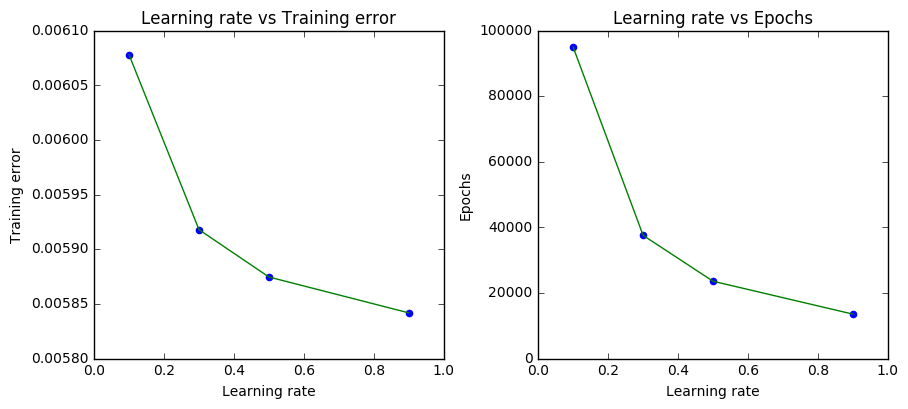

In [8]:
figure = plt.figure(1)
figure.set_figheight(5)
figure.set_figwidth(10)

figure.add_subplot(1, 2, 1)
plt.plot(learn_error[:,0], learn_error[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Training error')
plt.title('Learning rate vs Training error')
plt.scatter(learn_error[:,0], learn_error[:,1], color = 'b')

figure.add_subplot(1, 2, 2)
plt.tight_layout(pad= 4.00)
plt.plot(learn_epoch[:,0], learn_epoch[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Epochs')
plt.title('Learning rate vs Epochs')
plt.scatter(learn_epoch[:,0], learn_epoch[:,1], color = 'b')

plt.show()

## Comparision of convergence:

---

## Question 3:

Investigate the use of back-propagation learning using a sigmoidal nonlinearity to achieve one-to-one mappings, as described here:

For each mapping, do the following:

1. Set up two sets of data, one for network training, and the other for testing.

2. Use the training data set to compute the synaptic weights of the network, assumed to have a single hidden layer.

3. Evaluate the computation accuracy of the network by using the test data. Use a single hidden layer but with a variable number of hidden neurons. Investigate how the network performance is affected by varying the size of the hidden layer.

In [9]:
## Required functions....

def plot_results(hidden_neurons, train_error, test_error, 
                 plot_title, x_axis_lim = (None, None)):
    print 'Training error after convergence: '
    print '[Hidden neurons, converged training error]'
    print np.array(zip(hidden_neurons, train_error))
    print '--------------------------------------------------------------------'
    print 'Test error: '
    print '[Hidden neurons, test error]'
    print np.array(zip(hidden_neurons, test_error))

    plt.plot(hidden_neurons, train_error, color = 'r', label= "Training error")
    plt.plot(hidden_neurons, test_error, color = 'g', label= "Test error")
    plt.scatter(hidden_neurons, train_error, color = 'c', label= "Training error")
    plt.scatter(hidden_neurons, test_error, color = 'm', label= "Test error")
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Error')
    plt.title(plot_title)
    plt.xlim(x_axis_lim[0], x_axis_lim[1])
    plt.legend()
    plt.show()

def obtain_performance(x, y, hidden_neurons, normalizer= 1):
    data = np.hstack((x, y))/normalizer
    np.random.seed(0)
    np.random.shuffle(data)
    train_data, test_data = np.vsplit(data, [data.shape[0]*8/10])

    train_error = []
    test_error = []

    for number in hidden_neurons:
        network = NeuralNetwork(num_inputs= 1,
                            num_hidden_neurons= number)
        train_error.append(network.train(train_data[:,:-1],
                                     train_data[:,-1:])[0])
        test_error.append(network.predict(test_data[:,:-1],
                                     test_data[:,-1:]))
        
    return train_error, test_error

In [10]:
hidden_neurons = [1, 2, 3, 4, 5]

## 1) Reciprocal 
$$F(x) = \frac{1}{x}; 1<= x <=100$$

Epoch:  0 ...... Training Error:  0.599407540604
Epoch:  3000 ...... Training Error:  0.00272927287242
Epoch:  6000 ...... Training Error:  0.00189770968418
Epoch:  9000 ...... Training Error:  0.0015194359714
Epoch:  12000 ...... Training Error:  0.00128720745383
-----------------------------------------------------------
Epoch:  13584 ...... Training Error:  0.001195351317
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.658887285404
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.00090587606173
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.715819051878
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.000535470217268
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.79711377251
----

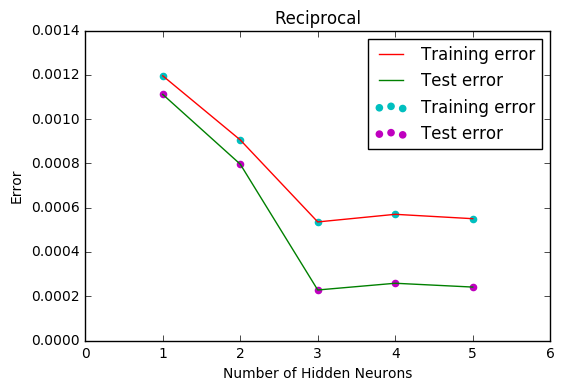

In [11]:
reciprocal_x = np.arange(1, 101, dtype= np.float32).reshape(-1, 1)
reciprocal_y = 1/reciprocal_x
train_error_r, test_error_r = obtain_performance(
    reciprocal_x, reciprocal_y, hidden_neurons, normalizer= 100)
plot_results(hidden_neurons, train_error_r, test_error_r, 'Reciprocal')

## 2) Log_10
$$F(x) = log_{10}x; 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.53014911191
-----------------------------------------------------------
Epoch:  263 ...... Training Error:  0.0255925091911
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.591338095427
-----------------------------------------------------------
Epoch:  94 ...... Training Error:  0.0303924405428
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.649293702376
-----------------------------------------------------------
Epoch:  62 ...... Training Error:  0.0304954351369
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.731407255769
-----------------------------------------------------------
Epoch:  48 ...... Training Error:  0.0301367772395
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Er

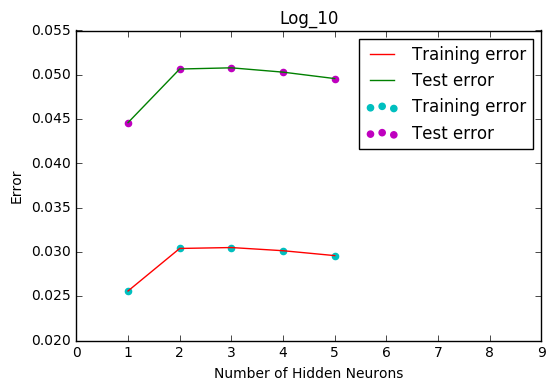

In [12]:
log_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
log_y = np.log10(log_x)
train_error_l, test_error_l = obtain_performance(
    log_x, log_y, hidden_neurons, normalizer= 10)
plot_results(hidden_neurons, train_error_l, test_error_l,
             'Log_10', x_axis_lim= (0, 9))

## 3) Exponential 
$$F(x) = exp(-x); 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.599774359737
-----------------------------------------------------------
Epoch:  43 ...... Training Error:  0.118361392347
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.660963343253
Epoch:  3000 ...... Training Error:  0.00520629200567
Epoch:  6000 ...... Training Error:  0.00391740249275
Epoch:  9000 ...... Training Error:  0.00325266024468
-----------------------------------------------------------
Epoch:  11206 ...... Training Error:  0.00291470743604
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.718918950202
Epoch:  3000 ...... Training Error:  0.00434973995671
Epoch:  6000 ...... Training Error:  0.00321542106106
-----------------------------------------------------------
Epoch:  7638 ...... Training Error:  0.00284227537736
Error has converged...
-------------------------------------------------------

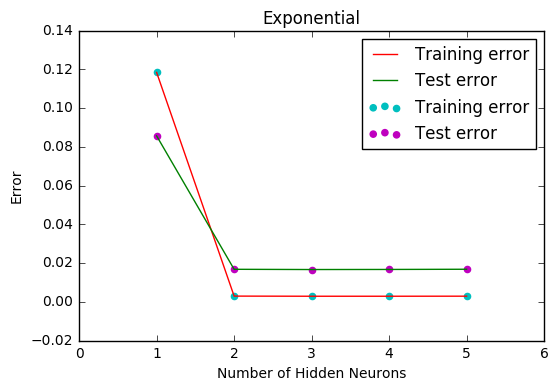

In [13]:
exp_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
exp_y = np.exp(-exp_x)
train_error_e, test_error_e = obtain_performance(
    exp_x, exp_y, hidden_neurons, normalizer= 10)
plot_results(hidden_neurons, train_error_e, test_error_e, 'Exponential')

## 4) Sinusoid 
$$F(x) = sin(x); 0<= x <=\frac{\pi}{2}$$

Epoch:  0 ...... Training Error:  0.203275728398
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.235544312756
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.257132127488
-----------------------------------------------------------
Epoch:  18 ...... Training Error:  0.0581010800769
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.314043537717
-----------------------------------------------------------
Epoch:  6 ...... Training Error:  0.164646474086
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.3953455152
-----------------------------------------------------------
Epoch:  24 ...... Training Error:  0.0681059782201
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  

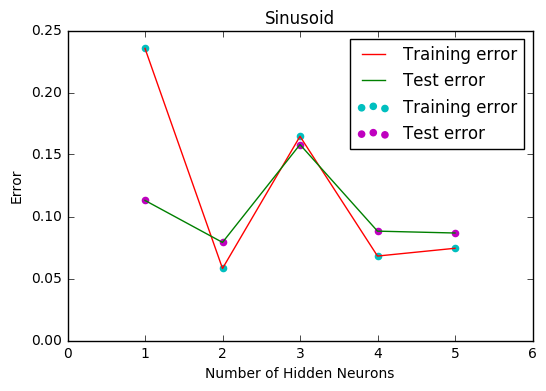

In [14]:
sin_x = np.linspace(0, np.pi/2, dtype= np.float32).reshape(-1, 1)
sin_y = np.sin(sin_x)
train_error_s, test_error_s = obtain_performance(
    sin_x, sin_y, hidden_neurons, normalizer= np.pi/2)
plot_results(hidden_neurons, train_error_s, test_error_s, 'Sinusoid')

---